In [1]:
import scanpy as sc
import anndata
import logging
import os
import numpy as np
import pandas as pd
# import scanpy.external as sce
logging.basicConfig(level=logging.INFO)

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns

# from PySpots.fish_helpers import *
from dredFISH.Analysis import basicu
from dredFISH.Analysis import celltypeu
from dredFISH.Analysis import TissueGraph as tgh

import importlib
importlib.reload(tgh)
importlib.reload(celltypeu)
sc.set_figure_params(figsize=(7, 7))

In [2]:
logging.info('hi')

INFO:root:hi


# file paths and load data

In [3]:
prj_dir = '/bigstore/GeneralStorage/fangming/projects/dredfish/'
dat_dir = prj_dir + 'data/'
res_dir = prj_dir + 'data_dump/'
fig_dir = prj_dir + 'figures/'

output_csv = f'{res_dir}noHarmony_March30_v3.csv'
print(output_csv)

# dredFISH data
dataset = 'DPNMF_PolyA_2021Nov19' # dataset tag
base_path = '/bigstore/Images2021/gaby/dredFISH/DPNMF_PolyA_2021Nov19/'
fish_path = f'{base_path}fishdata_2022Mar23/' # Zach's new version
# anndata_path = f'{base_path}results/raw_fishdata_Mar30.h5ad'
anndata_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/DPNMF_PolyA_2021Nov19_v2_results_anndata.h5ad'
# anndata_path = ''

# allen data
scrna_path = '/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/scrna_ss_ctxhippo_a_exon_DPNMF_matrix.h5ad'

/bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/noHarmony_March30_v3.csv


In [4]:
%%time
# load dredFISH
TMG = tgh.TissueMultiGraph(name=dataset)
# load raw counts data
if os.path.isfile(anndata_path):
    print('from AnnData')
    TMG.load_from_anndata(anndata_path)
else:
    print('from FishData')
    TMG.load_from_fishdata(fish_path, dataset, output_path=anndata_path)
# normalize (optional for spatial registration)
TMG.normalize_data(norm_cell=True, norm_bit=False)

### for now
data = TMG.data
# print(data)
    
# allen scrna matrix
ref_data = anndata.read_h5ad(scrna_path)
# print(ref_data)

from AnnData


INFO:root:113758 cells, minimum counts = 1248.0


CPU times: user 474 ms, sys: 128 ms, total: 603 ms
Wall time: 602 ms


In [5]:
# prepare
ref_data.obs = ref_data.obs.rename(columns={
    'class_label': 'Level_1_class_label', 
    'neighborhood_label': 'Level_2_neighborhood_label', 
    'subclass_label': 'Level_3_subclass_label', 
    # 'supertype_label', 
    'cluster_label': 'Level_5_cluster_label', 
})

celltype_levels = np.sort(ref_data.obs.filter(regex=r'^Level_[0-9]', axis=1).columns.values)
print(celltype_levels)

levels = celltype_levels[:3]      
X_data = np.array(data.layers['norm_cell'])
X_refdata = np.array(ref_data.X)
Y_refdata = ref_data.obs[levels].values

print(levels, X_data.shape, X_refdata.shape, Y_refdata.shape)

['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label' 'Level_5_cluster_label']
['Level_1_class_label' 'Level_2_neighborhood_label'
 'Level_3_subclass_label'] (113758, 24) (73347, 24) (73347, 3)


# run

In [7]:
# run
y_data = celltypeu.iterative_classify(
                 X_refdata,
                 Y_refdata,
                 X_data,
                 levels,
                 model=None,
                 verbose=True)

INFO:root:iteration 1/3
INFO:root:Current round: level_0
INFO:root:iteration 2/3
INFO:root:Current round: level_1_cluster_GABAergic
INFO:root:Current round: level_1_cluster_Glutamatergic
INFO:root:Current round: level_1_cluster_Non-Neuronal
INFO:root:iteration 3/3
INFO:root:Current round: level_2_cluster_CGE
INFO:root:Current round: level_2_cluster_MGE
INFO:root:Current round: level_2_cluster_Other
INFO:root:Current round: level_2_cluster_DG/SUB/CA
INFO:root:Current round: level_2_cluster_L2/3 IT
INFO:root:Current round: level_2_cluster_L4/5/6 IT Car3
INFO:root:Current round: level_2_cluster_NP/CT/L6b
INFO:root:Current round: level_2_cluster_Other
INFO:root:Current round: level_2_cluster_PT
INFO:root:Current round: level_2_cluster_Other


# Evaluate and save 

In [8]:
res = data.obs.copy() #pd.DataFrame(index=data.obs.index)
for i, level in enumerate(levels):
    res[level] = y_data[:,i]
res

label      pixel_x      pixel_y  \
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0         1.0    11.001562    86.770309   
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0         2.0     7.031977   249.014542   
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0         3.0    11.855099   797.958862   
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0         4.0    14.233974   951.783630   
DPNMF_PolyA_2021Nov19_Pos98_cell_5.0         5.0     4.344828   986.775879   
...                                          ...          ...          ...   
DPNMF_PolyA_2021Nov19_Pos102_cell_1357.0  1357.0  2041.041992   695.351379   
DPNMF_PolyA_2021Nov19_Pos102_cell_1358.0  1358.0  2037.588257  1224.082397   
DPNMF_PolyA_2021Nov19_Pos102_cell_1359.0  1359.0  2041.656616   649.783142   
DPNMF_PolyA_2021Nov19_Pos102_cell_1360.0  1360.0  2045.224976   582.000000   
DPNMF_PolyA_2021Nov19_Pos102_cell_1362.0  1362.0  2045.706909   550.568970   

                                          nuclei_size  nuclei_signal  \
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0            640.0        25904.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0            344.0        10288.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0            559.0        40080.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0            624.0        40800.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_5.0            174.0        49776.0   
...                                               ...            ...   
DPNMF_PolyA_2021Nov19_Pos102_cell_1357.0        333.0        53968.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1358.0         85.0        39376.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1359.0        166.0        26304.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1360.0         80.0        10432.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1362.0         58.0        38896.0   

                                          cytoplasm_size  cytoplasm_signal  \
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0               223.0           25840.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0                86.0           14240.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0               185.0           34112.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0               305.0           38144.0   
DPNMF_PolyA_2021Nov19_Pos98_cell_5.0               174.0           44896.0   
...                                                  ...               ...   
DPNMF_PolyA_2021Nov19_Pos102_cell_1357.0           306.0           42000.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1358.0          1197.0           43952.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1359.0           398.0           32912.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1360.0           145.0           20800.0   
DPNMF_PolyA_2021Nov19_Pos102_cell_1362.0           299.0           20848.0   

                                          total_size  total_signal posname  \
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0           851.0       25984.0   Pos98   
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0           428.0       10944.0   Pos98   
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0           737.0       38256.0   Pos98   
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0           800.0       42784.0   Pos98   
DPNMF_PolyA_2021Nov19_Pos98_cell_5.0           336.0       48496.0   Pos98   
...                                              ...           ...     ...   
DPNMF_PolyA_2021Nov19_Pos102_cell_1357.0       639.0       48800.0  Pos102   
DPNMF_PolyA_2021Nov19_Pos102_cell_1358.0      1324.0       43760.0  Pos102   
DPNMF_PolyA_2021Nov19_Pos102_cell_1359.0       564.0       31136.0  Pos102   
DPNMF_PolyA_2021Nov19_Pos102_cell_1360.0       201.0       18336.0  Pos102   
DPNMF_PolyA_2021Nov19_Pos102_cell_1362.0       357.0       23312.0  Pos102   

                                          ...      stage_x      stage_y  \
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0      ... -2413.586509  3496.712879   
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0      ... -2412.292424  3443.821259   
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0      ... -2413.864762  3264.865411   
DPNMF_PolyA_2021Nov19_Pos98_cell_4.0      ... -2414.640276  3214.71

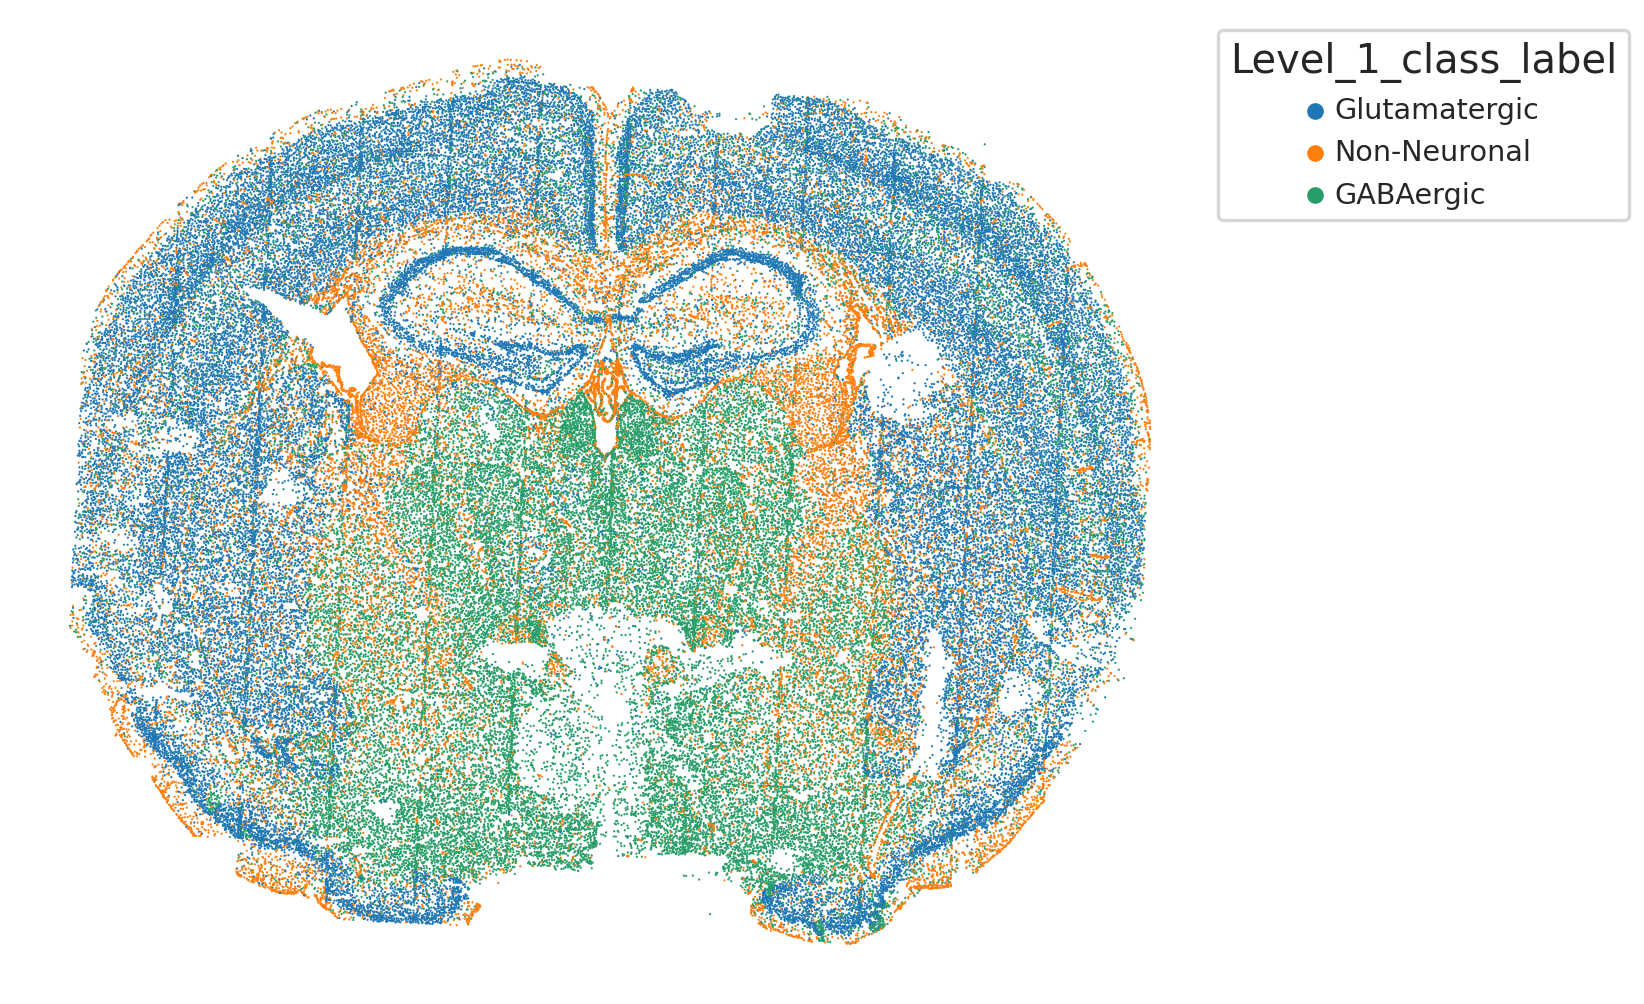

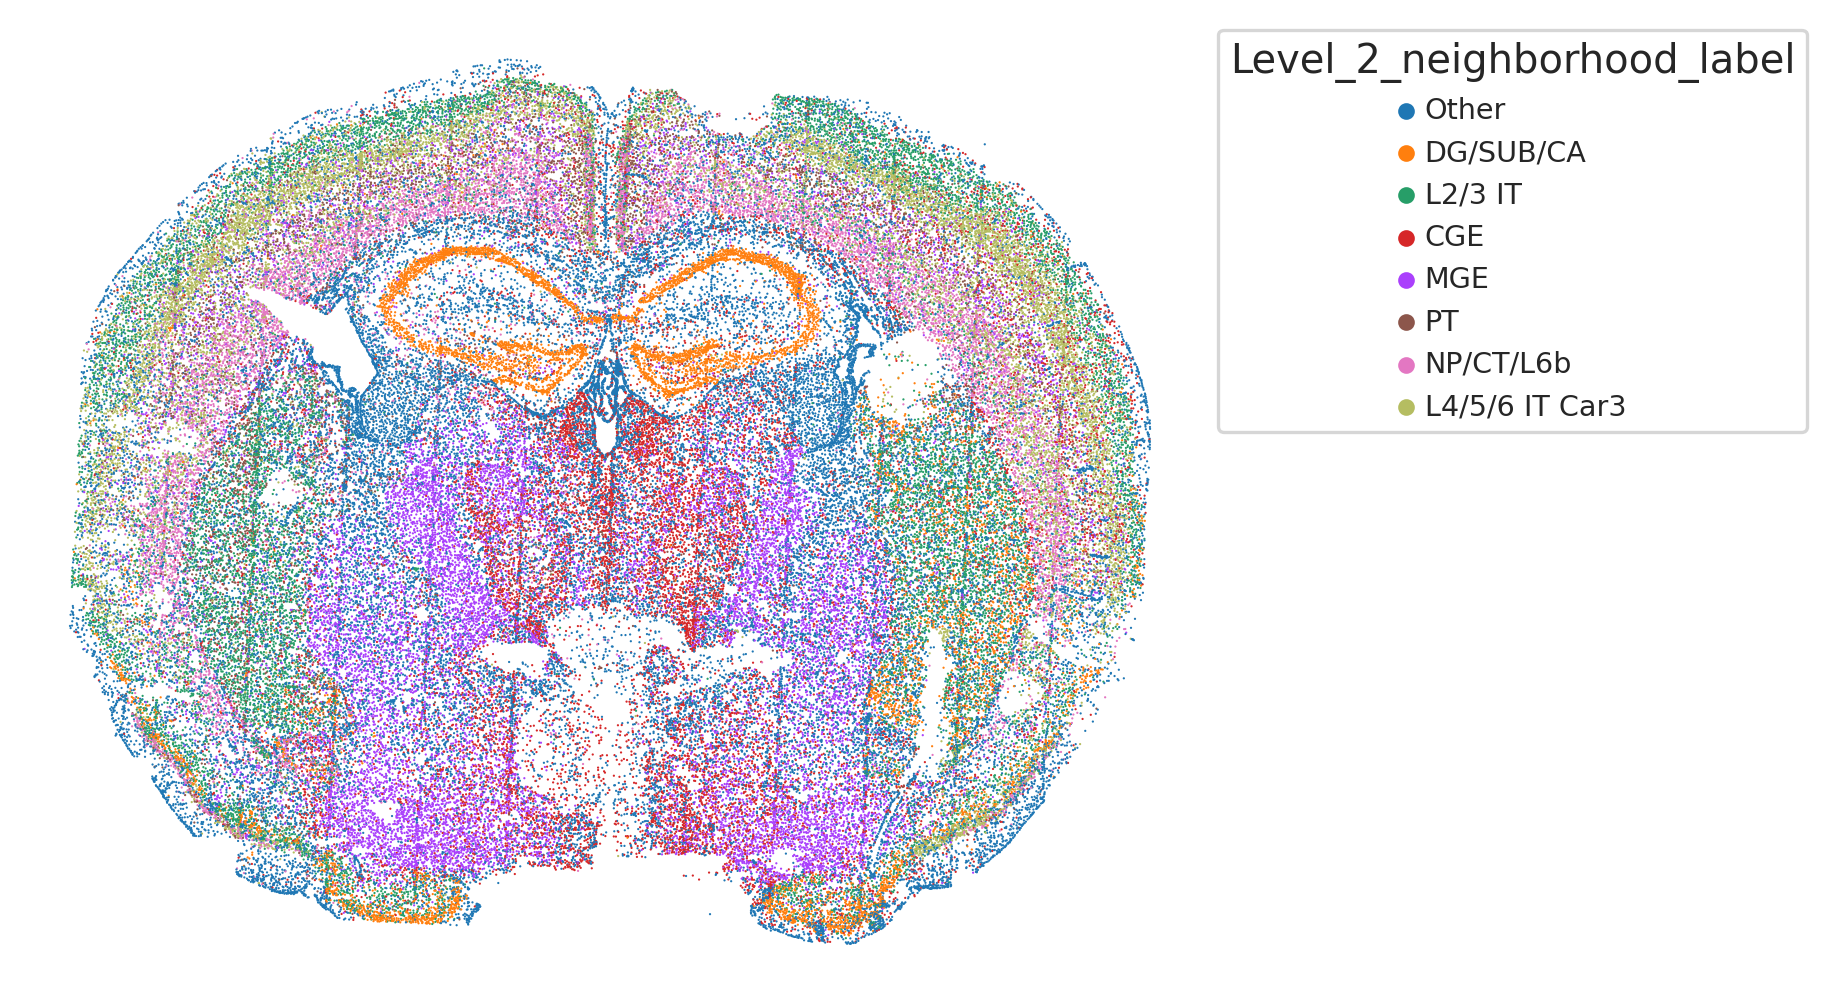

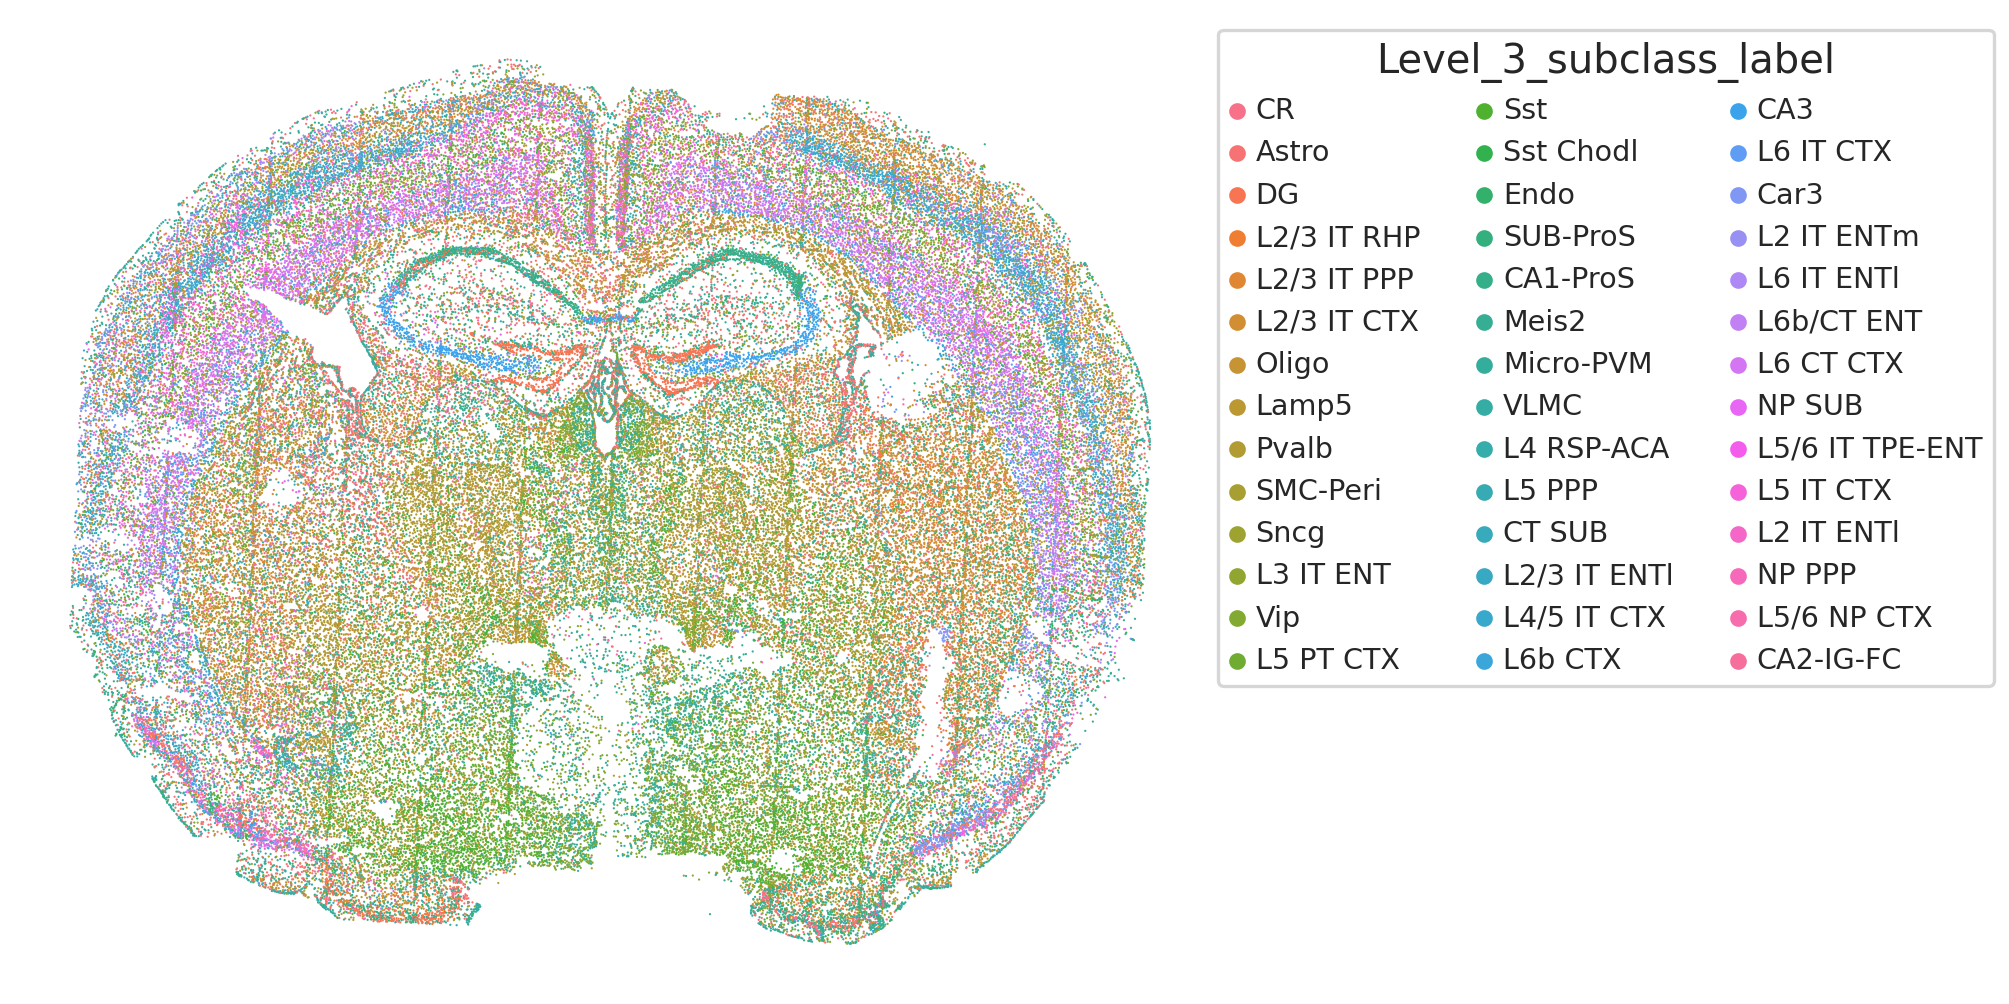

In [9]:
for level in levels:
    fig, ax = plt.subplots(figsize=(10,8))
    sns.scatterplot(data=res, x='coord_x', y='coord_y', hue=level,
                    # hue_order=np.sort(np.unique(res[level])),
                    s=1,
                    edgecolor='none',
                    rasterized=True,
                   )
    ax.axis('off')
    ax.legend(bbox_to_anchor=(1,1), 
              loc='upper left', 
              ncol=1+int(len(np.unique(res[level]))/20), 
              title=level,
             )
    ax.invert_yaxis()
    ax.set_aspect('equal')
    plt.show()

In [10]:
res.to_csv(output_csv, header=True, index=True)

In [11]:
# !head $output_csv
!wc -l $output_csv

113759 /bigstore/GeneralStorage/fangming/projects/dredfish/data_dump/noHarmony_March30_v3.csv


In [12]:
!head $output_csv

,label,pixel_x,pixel_y,nuclei_size,nuclei_signal,cytoplasm_size,cytoplasm_signal,total_size,total_signal,posname,posname_stage_x,posname_stage_y,cell_name,stage_x,stage_y,coord_x,coord_y,region_id,region_color,region_acronym,Level_1_class_label,Level_2_neighborhood_label,Level_3_subclass_label
DPNMF_PolyA_2021Nov19_Pos98_cell_1.0,1.0,11.001562118530273,86.77030944824219,640.0,25904.0,223.0,25840.0,851.0,25984.0,Pos98,-2410.0,3525.0,DPNMF_PolyA_2021Nov19_Pos98_cell_1.0,-2413.586509250641,3496.712879119873,3066.6327916763257,582.5747034367021,574,#98D6F9,CP,Glutamatergic,Other,CR
DPNMF_PolyA_2021Nov19_Pos98_cell_2.0,2.0,7.031976699829102,249.01454162597656,344.0,10288.0,86.0,14240.0,428.0,10944.0,Pos98,-2410.0,3525.0,DPNMF_PolyA_2021Nov19_Pos98_cell_2.0,-2412.292424404144,3443.8212594299316,3013.8600985095522,578.800985781541,1202,#CCCCCC,int,Non-Neuronal,Other,Astro
DPNMF_PolyA_2021Nov19_Pos98_cell_3.0,3.0,11.855098724365234,797.9588623046875,559.0,40080.0,185.0,34112.0,737.0,38256.0,Po